In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
data = pd.read_csv('../artifacts/sentiment_analysis.csv')

In [56]:
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


Datav Preprocessing

In [57]:
data.shape

(7920, 3)

In [58]:
data.duplicated().sum()

np.int64(0)

In [59]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

Text Preprocessing

In [60]:
import re
import string

In [61]:
data['tweet'].head()

0    #fingerprint #Pregnancy Test https://goo.gl/h1...
1    Finally a transparant silicon case ^^ Thanks t...
2    We love this! Would you go? #talk #makememorie...
3    I'm wired I know I'm George I was made that wa...
4    What amazing service! Apple won't even talk to...
Name: tweet, dtype: object

convert uppercase to lowercase

In [62]:
data['tweet'] = data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [63]:
data['tweet'].head()

0    #fingerprint #pregnancy test https://goo.gl/h1...
1    finally a transparant silicon case ^^ thanks t...
2    we love this! would you go? #talk #makememorie...
3    i'm wired i know i'm george i was made that wa...
4    what amazing service! apple won't even talk to...
Name: tweet, dtype: object

remove links

In [64]:
data['tweet'] = data['tweet'].apply(lambda x: " ".join(re.sub(r'^https?:\/\/.*[\r\n]*','', x, flags = re.MULTILINE) for x in x.split()))

In [65]:
data['tweet'].head()

0    #fingerprint #pregnancy test  #android #apps #...
1    finally a transparant silicon case ^^ thanks t...
2    we love this! would you go? #talk #makememorie...
3    i'm wired i know i'm george i was made that wa...
4    what amazing service! apple won't even talk to...
Name: tweet, dtype: object

Remove Punctuation

In [66]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [67]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
data['tweet'] = data['tweet'].apply(remove_punctuation)



In [68]:
data['tweet'].head()

0    fingerprint pregnancy test  android apps beaut...
1    finally a transparant silicon case  thanks to ...
2    we love this would you go talk makememories un...
3    im wired i know im george i was made that way ...
4    what amazing service apple wont even talk to m...
Name: tweet, dtype: object

Remove Numbers

In [69]:
data['tweet'] = data['tweet'].str.replace('\d+', '', regex=True)

In [70]:
!pip install nltk

In [71]:
import nltk

In [72]:
nltk.download('stopwords' , download_dir = "../static/model")

[nltk_data] Downloading package stopwords to ../static/model...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
with open('../static/model/corpora/stopwords/english', 'r') as file:
    sw = file.read().splitlines()

In [74]:
data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [75]:
data['tweet'].head()

0    fingerprint pregnancy test android apps beauti...
1    finally transparant silicon case thanks uncle ...
2    love would go talk makememories unplug relax i...
3    im wired know im george made way iphone cute d...
4    amazing service apple wont even talk question ...
Name: tweet, dtype: object

Stemming(Get base word for all words [goes going = go])

In [76]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [77]:
data['tweet'] = data['tweet'].apply(lambda x: " ".join(ps.stem(x) for x in x.split()))

In [78]:
data['tweet'].head()

0    fingerprint pregnanc test android app beauti c...
1    final transpar silicon case thank uncl yay son...
2    love would go talk makememori unplug relax iph...
3    im wire know im georg made way iphon cute dave...
4    amaz servic appl wont even talk question unles...
Name: tweet, dtype: object

Building Vocabulary

In [79]:
from collections import Counter
vocab = Counter()

In [80]:
for sentence in data['tweet']:
    vocab.update(sentence.split())

In [81]:
len(vocab)

15949

In [82]:
tokens = [key for key in vocab if vocab[key]>10]

In [83]:
len(tokens)

1145

In [84]:
def save_vocabulary(lines, filename):
    data = '\n'.join(lines)  
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(data)

save_vocabulary(tokens, '../static/model/vocabulary.txt')


Divide dataset

In [85]:
x = data['tweet']
y = data['label']

In [86]:
!pip install scikit-learn

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [88]:
len(x_test)

1584

Vectorization

In [89]:
def vectorizer(ds, vocabulary):
    vectorized_lst = []
    for sentence in ds:
        sentence_lst = np.zeros(len(vocabulary))
        for i in range(len(vocabulary)):
            if vocabulary[i] in sentence.split():
                sentence_lst[i] = 1

        vectorized_lst.append(sentence_lst)

    vectorized_lst_new = np.asarray(vectorized_lst, dtype=np.float32)

    return  vectorized_lst_new
            

In [90]:
vectorized_x_train = vectorizer(x_train, tokens)

In [91]:
vectorized_x_test = vectorizer(x_test, tokens)

In [92]:
y_train.value_counts()

label
0    4674
1    1662
Name: count, dtype: int64

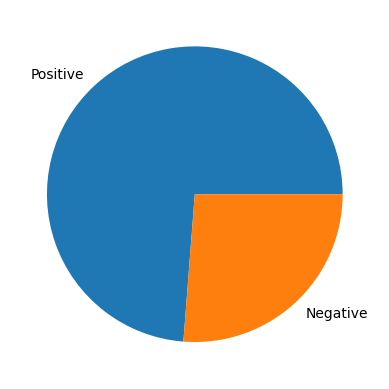

In [93]:
plt.pie(np.array([y_train.value_counts()[0],y_train.value_counts()[1]]),labels=['Positive','Negative'])
plt.show()

Haddle Imbalanced Dataset

In [94]:
!pip install imbalanced-learn

In [95]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorized_x_train, y_train)
print(vectorized_x_train_smote.shape, y_train.shape)

(9348, 1145) (6336,)


In [96]:
y_train_smote.value_counts()

label
0    4674
1    4674
Name: count, dtype: int64

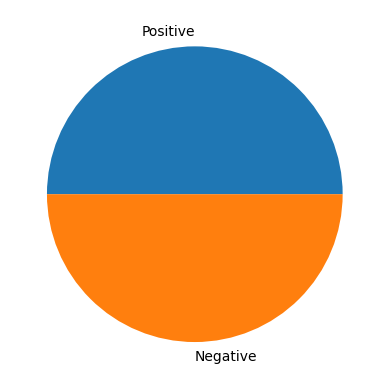

In [97]:
plt.pie(np.array([y_train_smote.value_counts()[0],y_train_smote.value_counts()[1]]),labels=['Positive','Negative'])
plt.show()

In [98]:
vectorized_x_train_smote

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [99]:
y_train_smote

0       0
1       1
2       0
3       0
4       0
       ..
9343    1
9344    1
9345    1
9346    1
9347    1
Name: label, Length: 9348, dtype: int64

In [100]:
vectorized_x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [101]:
y_test

3301    1
661     0
4738    1
3183    0
4008    0
       ..
1794    1
6305    0
2559    0
6070    0
3638    0
Name: label, Length: 1584, dtype: int64

Model Training and Evaluation

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall= {rec}\n\tF1-Score= {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall= {rec}\n\tF1-Score= {f1}')

Logistic Regression

In [105]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote )

y_train_pred = lr.predict(vectorized_x_train_smote)

y_test_pred = lr.predict(vectorized_x_test)

training_scores(y_train_smote,y_train_pred)

validation_scores(y_test, y_test_pred)


Testing Scores:
	Accuracy = 0.939
	Precision = 0.914
	Recall= 0.97
	F1-Score= 0.941
Testing Scores:
	Accuracy = 0.87
	Precision = 0.671
	Recall= 0.852
	F1-Score= 0.751


Naive Bayes

In [106]:
mnb = MultinomialNB()
mnb.fit(vectorized_x_train_smote, y_train_smote )

y_train_pred = mnb.predict(vectorized_x_train_smote)

y_test_pred = mnb.predict(vectorized_x_test)

training_scores(y_train_smote,y_train_pred)

validation_scores(y_test, y_test_pred)


Testing Scores:
	Accuracy = 0.904
	Precision = 0.869
	Recall= 0.952
	F1-Score= 0.909
Testing Scores:
	Accuracy = 0.86
	Precision = 0.634
	Recall= 0.92
	F1-Score= 0.751


Decision Tree

In [107]:
dt = DecisionTreeClassifier()
dt.fit(vectorized_x_train_smote, y_train_smote )

y_train_pred = dt.predict(vectorized_x_train_smote)

y_test_pred = dt.predict(vectorized_x_test)

training_scores(y_train_smote,y_train_pred)

validation_scores(y_test, y_test_pred)


Testing Scores:
	Accuracy = 1.0
	Precision = 1.0
	Recall= 0.999
	F1-Score= 1.0
Testing Scores:
	Accuracy = 0.83
	Precision = 0.618
	Recall= 0.679
	F1-Score= 0.647


Random Forest

In [108]:
rf = RandomForestClassifier()
rf.fit(vectorized_x_train_smote, y_train_smote )

y_train_pred = rf.predict(vectorized_x_train_smote)

y_test_pred = rf.predict(vectorized_x_test)

training_scores(y_train_smote,y_train_pred)

validation_scores(y_test, y_test_pred)


Testing Scores:
	Accuracy = 1.0
	Precision = 0.999
	Recall= 1.0
	F1-Score= 1.0
Testing Scores:
	Accuracy = 0.878
	Precision = 0.724
	Recall= 0.758
	F1-Score= 0.741


In [ ]:
Support Vector Machine

In [109]:
svc = SVC()
svc.fit(vectorized_x_train_smote, y_train_smote )

y_train_pred = svc.predict(vectorized_x_train_smote)

y_test_pred = svc.predict(vectorized_x_test)

training_scores(y_train_smote,y_train_pred)

validation_scores(y_test, y_test_pred)


Testing Scores:
	Accuracy = 0.976
	Precision = 0.959
	Recall= 0.995
	F1-Score= 0.977
Testing Scores:
	Accuracy = 0.883
	Precision = 0.71
	Recall= 0.832
	F1-Score= 0.766


In [110]:
import pickle

with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(lr,file)
    